Installation und Import der nötigen Bibliotheken

In [185]:
%pip install pandas
%pip install matplotlib
%pip install pillow


import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Einlesen der CSVs

In [186]:
cmf_path = '../input files/cmf.csv'
spectrum_path = '../input files/CIE_std_illum_D65.csv'

#columns_cmf = ["Wavelength", "x", "y", "z", "Column1", "Column2", "Column3", "Column4"]
columns_cmf = ["Column1", "Column2", "Column3", "Column4", "Wavelength", "x", "y", "z"]
columns_spectrum = ["Wellenlänge", "Intensität"]

cmf = pd.read_csv(cmf_path, header=None, names=columns_cmf)
cmf = cmf.drop(columns=["Column1", "Column2", "Column3", "Column4"])
spectrum = pd.read_csv(spectrum_path, header=None, names=columns_spectrum)
spectrum = spectrum[(spectrum['Wellenlänge'] >= 380) & (spectrum['Wellenlänge'] <= 780)]
spectrum = spectrum[spectrum['Wellenlänge'] % 5 == 0]

print("CMF DataFrame 1:")
print(cmf.head())

print("\nSpectrum DataFrame 2:")
print(spectrum.head())

CMF DataFrame 1:
   Wavelength       x       y       z
0         380  0.0002  0.0000  0.0007
1         385  0.0007  0.0001  0.0029
2         390  0.0024  0.0003  0.0105
3         395  0.0072  0.0008  0.0323
4         400  0.0191  0.0020  0.0860

Spectrum DataFrame 2:
     Wellenlänge  Intensität
80           380     49.9755
85           385     52.3118
90           390     54.6482
95           395     68.7015
100          400     82.7549


Anwendung der CMF

In [187]:
merged_df = pd.merge(spectrum, cmf, left_on='Wellenlänge', right_on='Wavelength')

merged_df['CMF(x)'] = merged_df['Intensität'] * merged_df['x']
merged_df['CMF(y)'] = merged_df['Intensität'] * merged_df['y']
merged_df['CMF(z)'] = merged_df['Intensität'] * merged_df['z']

merged_df = merged_df.drop(columns=['Wavelength'])

print("Merged Spectrum DataFrame:")
print(merged_df)

Merged Spectrum DataFrame:
    Wellenlänge  Intensität       x       y       z    CMF(x)    CMF(y)  \
0           380     49.9755  0.0002  0.0000  0.0007  0.009995  0.000000   
1           385     52.3118  0.0007  0.0001  0.0029  0.036618  0.005231   
2           390     54.6482  0.0024  0.0003  0.0105  0.131156  0.016394   
3           395     68.7015  0.0072  0.0008  0.0323  0.494651  0.054961   
4           400     82.7549  0.0191  0.0020  0.0860  1.580619  0.165510   
..          ...         ...     ...     ...     ...       ...       ...   
76          760     46.4182  0.0001  0.0000  0.0000  0.004642  0.000000   
77          765     56.6118  0.0001  0.0000  0.0000  0.005661  0.000000   
78          770     66.8054  0.0001  0.0000  0.0000  0.006681  0.000000   
79          775     65.0941  0.0000  0.0000  0.0000  0.000000  0.000000   
80          780     63.3828  0.0000  0.0000  0.0000  0.000000  0.000000   

      CMF(z)  
0   0.034983  
1   0.151704  
2   0.573806  
3   2.219058

Aufsummierung

In [188]:
sum_CMF_x = merged_df['CMF(x)'].sum()
sum_CMF_y = merged_df['CMF(y)'].sum()
sum_CMF_z = merged_df['CMF(z)'].sum()

print(f"Summe CMF(x): {sum_CMF_x}")
print(f"Summe CMF(y): {sum_CMF_y}")
print(f"Summe CMF(z): {sum_CMF_z}")

output_path = '../output files/spectrum_output.csv'
merged_df.to_csv(output_path, index=False)

Summe CMF(x): 2202.77668746
Summe CMF(y): 2326.61400049
Summe CMF(z): 2494.31954813


Normalisierung

In [189]:
total_sum = sum_CMF_x + sum_CMF_y + sum_CMF_z
x = sum_CMF_x / total_sum
y = sum_CMF_y / total_sum

print(f"x: {x}")
print(f"y: {y}")

x: 0.31362009727345913
y: 0.3312514215832038


Fehlerinjektion in CMF

In [190]:
cmf_fault = cmf.copy()
cmf_fault['Wavelength'] += 10

merged_fault_df = pd.merge(spectrum, cmf_fault, left_on='Wellenlänge', right_on='Wavelength', how='left')

merged_fault_df['CMF(x)'] = merged_fault_df['Intensität'] * merged_fault_df['x']
merged_fault_df['CMF(y)'] = merged_fault_df['Intensität'] * merged_fault_df['y']
merged_fault_df['CMF(z)'] = merged_fault_df['Intensität'] * merged_fault_df['z']

merged_fault_df = merged_fault_df.drop(columns=['Wavelength'])

sum_CMF_x_fault = merged_fault_df['CMF(x)'].sum()
sum_CMF_y_fault = merged_fault_df['CMF(y)'].sum()
sum_CMF_z_fault = merged_fault_df['CMF(z)'].sum()

total_sum_fault = sum_CMF_x_fault + sum_CMF_y_fault + sum_CMF_z_fault
x_fault = sum_CMF_x_fault / total_sum_fault
y_fault = sum_CMF_y_fault / total_sum_fault

print(f"Summe CMF(x) with fault: {sum_CMF_x_fault}")
print(f"Summe CMF(y) with fault: {sum_CMF_y_fault}")
print(f"Summe CMF(z) with fault: {sum_CMF_z_fault}")
print(f"x with fault: {x_fault}")
print(f"y with fault: {y_fault}")

output_path_fault = '../output files/spectrum_output_fault.csv'
merged_fault_df.to_csv(output_path_fault, index=False)

Summe CMF(x) with fault: 2180.58580558
Summe CMF(y) with fault: 2284.59584614
Summe CMF(z) with fault: 2572.42020593
x with fault: 0.30984785011810007
y with fault: 0.32462703806646903


Mapping auf CIE xy chromaticity diagram

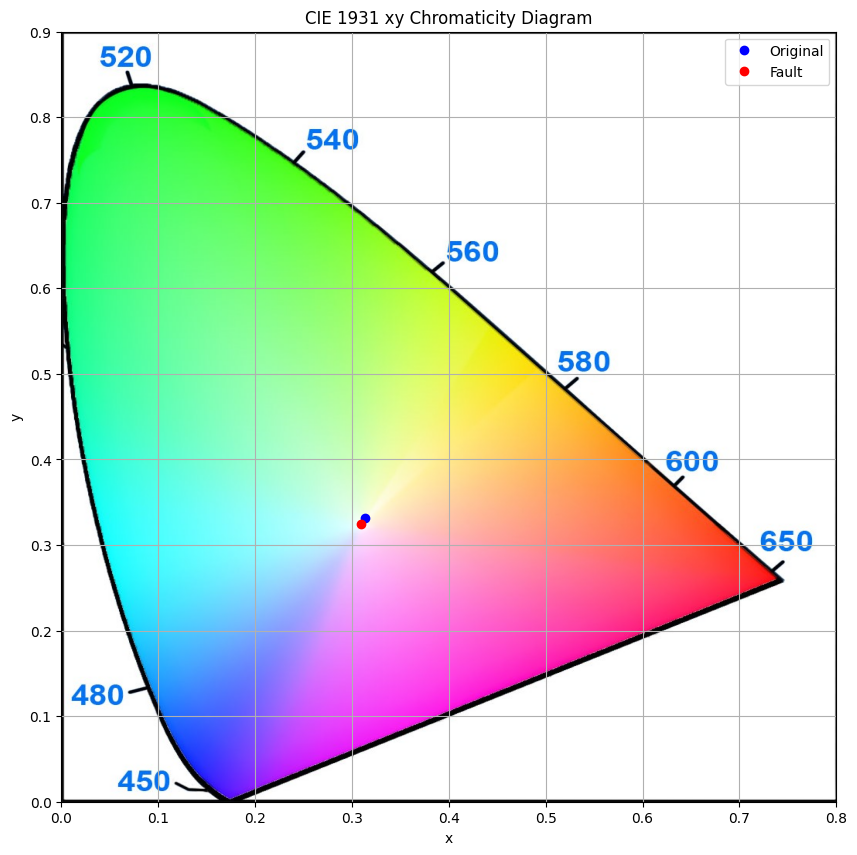

In [191]:
def plot_and_save_chromaticity_diagram(x, y, x_fault, y_fault, save_path):
    cie_diagram_path = '../input files/CIE_1931_Chromaticity_Diagram.jpg'
    cie_diagram = Image.open(cie_diagram_path)

    plt.figure(figsize=(10, 10))

    plt.imshow(cie_diagram, extent=[0, 0.8, 0, 0.9], aspect='auto')

    plt.plot(x, y, 'bo', label='Original')
    plt.plot(x_fault, y_fault, 'ro', label='Fault')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('CIE 1931 xy Chromaticity Diagram')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 0.8)
    plt.ylim(0, 0.9)

    plt.savefig(save_path, format='png')
    plt.show()

save_path = '../output files/cie1931_chromaticity_diagram.png'
plot_and_save_chromaticity_diagram(x, y, x_fault, y_fault, save_path)